# Issues with covariance in Gammapy

In [245]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_irf_dict_from_file
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    FoVBackgroundModel,
Models,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit, Covariance
from gammapy.data import Observation
from gammapy.datasets import MapDataset, Datasets
from gammapy.estimators import ExcessMapEstimator
from gammapy.visualization.utils import plot_contour_line


In [159]:
dataset1 = MapDataset.read("dataset_cov1.fits.gz", name="dataset1")
dataset2 = MapDataset.read("dataset_cov2.fits.gz", name="dataset2")
datasets = Datasets([dataset1, dataset2])

In [160]:
bkg1 = FoVBackgroundModel(dataset_name=dataset1.name)
bkg2 = FoVBackgroundModel(dataset_name=dataset2.name)


In [161]:
spatial_model = GaussianSpatialModel(frame="galactic")
spectral_model = PowerLawSpectralModel()
spatial_model.sigma.value = 0.3
spectral_model.amplitude.value = 5e-12
sky_model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="sky_model",
)

In [162]:
models = Models([bkg1, bkg2, sky_model])
datasets.models = models

In [163]:
fit = Fit()
res1 = fit.run(datasets)

In [164]:
res1.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str12,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
dataset1-bkg,,norm,1.0952e+00,,2.684e-03,nan,nan,False,True,,
dataset1-bkg,,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,,
dataset1-bkg,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
sky_model,,index,2.0964e+00,,7.830e-02,nan,nan,False,False,,
sky_model,,amplitude,2.3933e-12,TeV-1 s-1 cm-2,2.879e-13,nan,nan,False,True,,
sky_model,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
sky_model,,lon_0,-1.3019e-02,deg,6.314e-02,nan,nan,False,False,,
sky_model,,lat_0,1.8665e-03,deg,5.942e-02,-9.000e+01,9.000e+01,False,False,,
sky_model,,sigma,5.6042e-01,deg,4.555e-02,0.000e+00,nan,False,False,,


<Axes: >

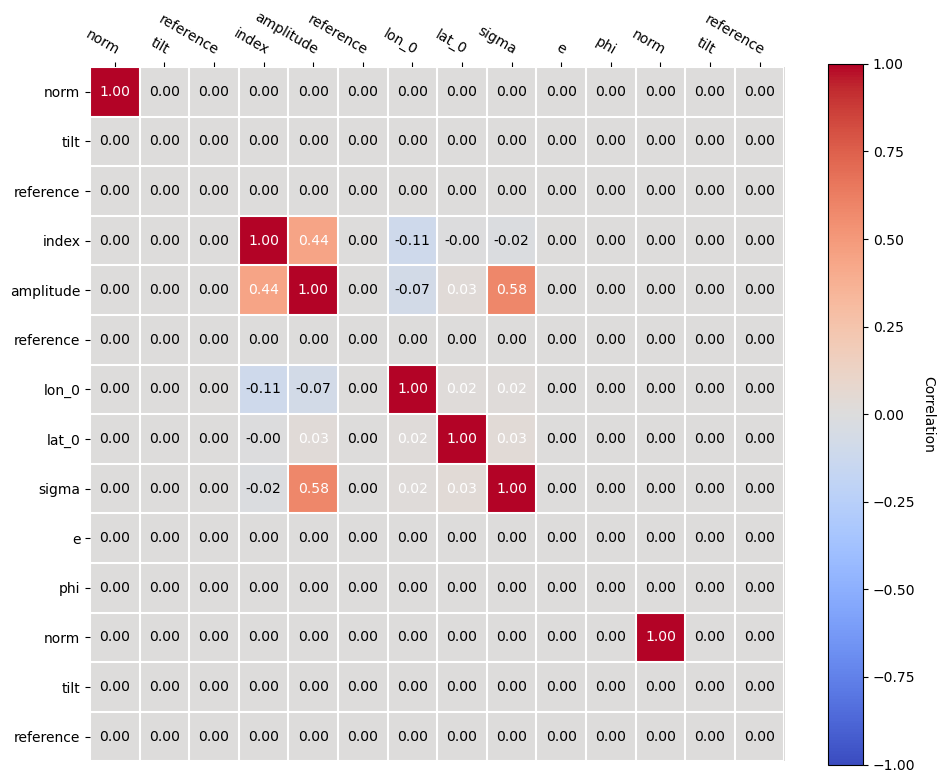

In [165]:
datasets.models.covariance.plot_correlation()

<Axes: >

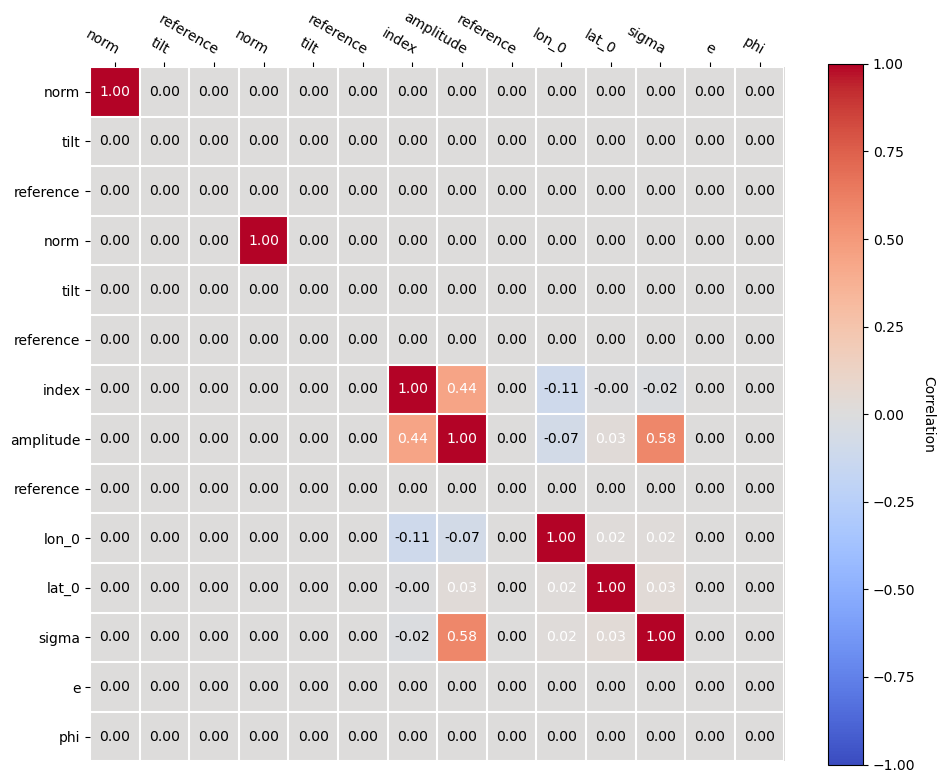

In [166]:
models.covariance.plot_correlation()

Possible to set the matrix by hand, but order of paramters weird

In [167]:
models.covariance = Covariance(data=res1.covariance_result.matrix, parameters=res1.models.parameters)

<Axes: >

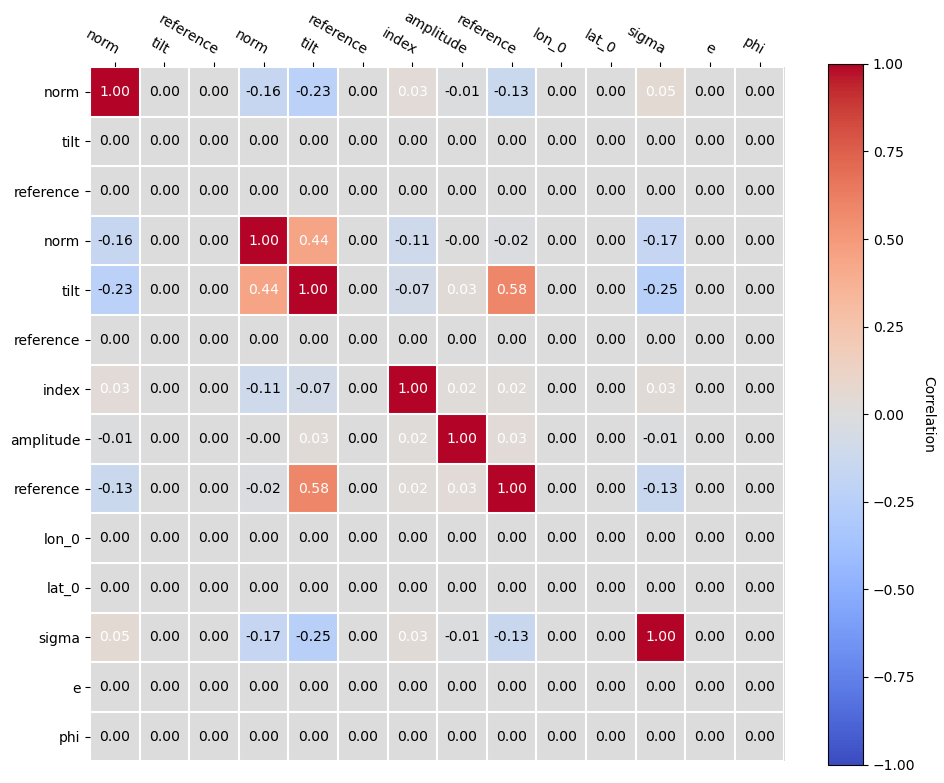

In [168]:
models.covariance.plot_correlation()

## Issue
1. No correlation between parameters of different models? eg: `norm` and `amplitude`
2. The global covariance is just the stacking of individual covariances
3. Setting the covariance by hand, order of parameters?
4. Serialisation - `datasets.models.covariance` is written, which is always incomple

In [169]:
datasets.write??

Signature:
datasets.write(
    filename,
    filename_models=None,
    overwrite=False,
    write_covariance=True,
    checksum=False,
)
Source:   
    def write(
        self,
        filename,
        filename_models=None,
        overwrite=False,
        write_covariance=True,
        checksum=False,
    ):
        """Serialize datasets to YAML and FITS files.

        Parameters
        ----------
        filename : str or `~pathlib.Path`
            File path or name of datasets yaml file.
        filename_models : str or `~pathlib.Path`, optional
            File path or name of models yaml file. Default is None.
        overwrite : bool, optional
            Overwrite existing file. Default is False.
        write_covariance : bool
            save covariance or not. Default is False.
        checksum : bool
            When True adds both DATASUM and CHECKSUM cards to the headers written to the FITS files.
            Default is False.
        """
        path = make_path(filen

In [170]:
contour3 = fit.stat_contour(
                datasets=datasets,
                x=datasets.parameters["sigma"],
                y=datasets.parameters["amplitude"],
                numpoints=11,
                sigma=1,
            )

/Users/atreyeesinha/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/atreyeesinha/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/atreyeesinha/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/atreyeesinha/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/atreyeesinha/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units

Text(0, 0.5, 'sky_model.spectral.amplitude')

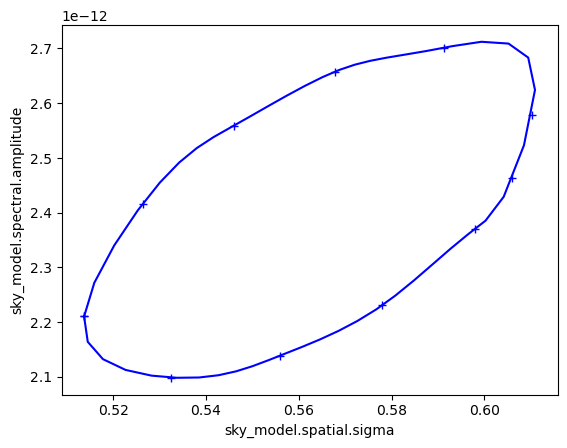

In [172]:
ax= plt.subplot()
plot_contour_line(ax=ax,
                  x=contour3['sky_model.spatial.sigma'],
                  y=contour3['sky_model.spectral.amplitude'])
ax.set_xlabel('sky_model.spatial.sigma')
ax.set_ylabel('sky_model.spectral.amplitude')

In [173]:
contour4 = fit.stat_contour(
                datasets=datasets,
                x=datasets.parameters["norm"],
                y=datasets.parameters["amplitude"],
                numpoints=11,
                sigma=1,
            )

/Users/atreyeesinha/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/atreyeesinha/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/atreyeesinha/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/atreyeesinha/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/atreyeesinha/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units

E MnContours unable to find point on Contour 5 
 found only 4 points


In [174]:
contour4

{'dataset1-bkg.spectral.norm': array([1.09249471, 1.09583137, 1.09791165, 1.0945335 , 1.09249471]),
 'sky_model.spectral.amplitude': array([2.46851382e-12, 2.09844608e-12, 2.32245221e-12, 2.70136558e-12,
        2.46851382e-12]),
 'success': True}

Text(0, 0.5, 'sky_model.spectral.amplitude')

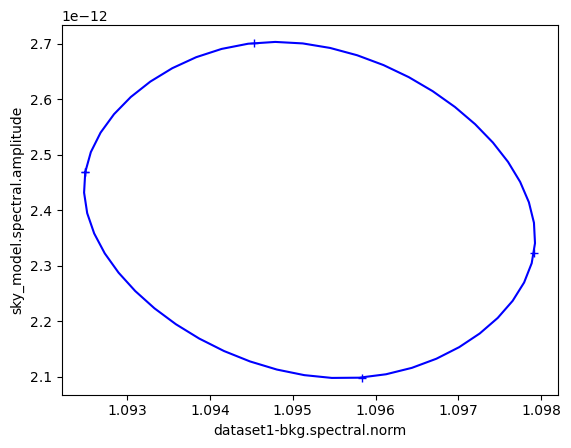

In [175]:
ax= plt.subplot()
plot_contour_line(ax=ax,
                  x=contour4['dataset1-bkg.spectral.norm'],
                  y=contour4['sky_model.spectral.amplitude'])
ax.set_xlabel('dataset1-bkg.spectral.norm')
ax.set_ylabel('sky_model.spectral.amplitude')

In [176]:
contour2 = fit.stat_contour(
                datasets=datasets,
                x=bkg1.parameters["norm"],
                y=bkg2.parameters["norm"],
                numpoints=11,
                sigma=1,
            )

/Users/atreyeesinha/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/atreyeesinha/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/atreyeesinha/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/atreyeesinha/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in subtract
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/atreyeesinha/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/astropy/units

In [177]:
contour2

{'dataset1-bkg.spectral.norm': array([1.09249471, 1.09324094, 1.09500992, 1.09702567, 1.09767307,
        1.09791165, 1.09716065, 1.09536664, 1.09428352, 1.09335935,
        1.09272398, 1.09249471]),
 'dataset2-bkg.spectral.norm': array([1.02365579, 1.02190951, 1.02121878, 1.02202133, 1.02292013,
        1.02400183, 1.02577301, 1.02646774, 1.02625048, 1.02564528,
        1.02473878, 1.02365579]),
 'success': True}

Text(0, 0.5, 'dataset2-bkg.spectral.norm')

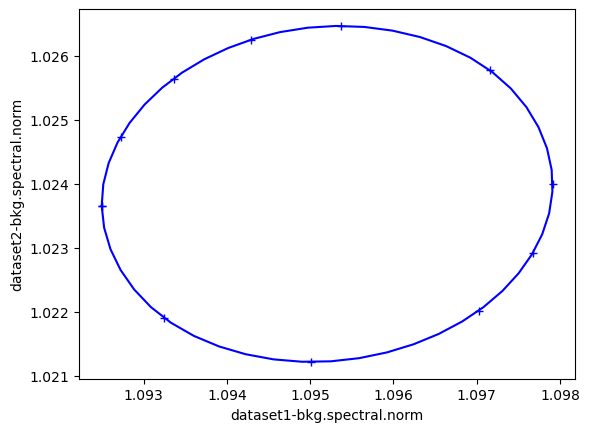

In [178]:
ax= plt.subplot()
plot_contour_line(ax=ax,
                  x=contour2['dataset1-bkg.spectral.norm'],
                  y=contour2['dataset2-bkg.spectral.norm'])
ax.set_xlabel('dataset1-bkg.spectral.norm')
ax.set_ylabel('dataset2-bkg.spectral.norm')

## Example with a spectral model

In [214]:
ds1_sp = dataset1.to_spectrum_dataset(on_region=sky_model.spatial_model.to_region(), name="spectral_ds")

(<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='$\\mathrm{}$'>,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals\ndata - model'>)

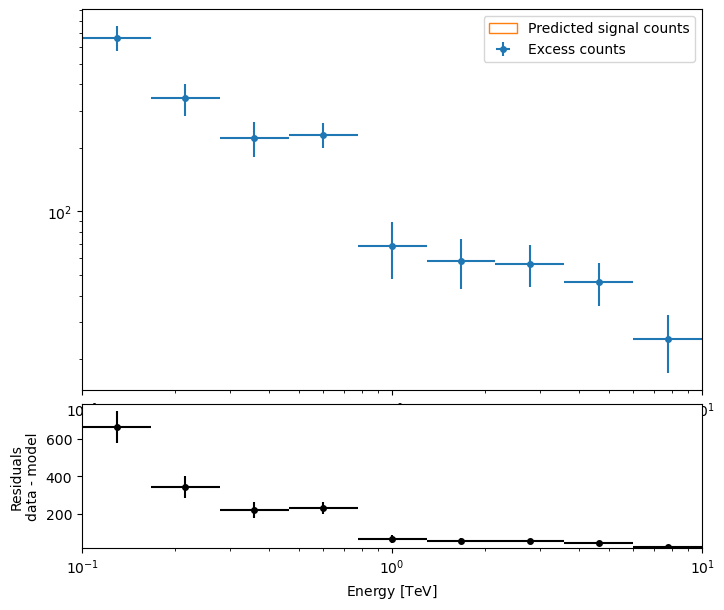

In [215]:
ds1_sp.plot_fit()

In [233]:
spectral1 = PowerLawSpectralModel()
model1 = SkyModel(spectral_model=spectral1, name="model1")
bkg_sp = FoVBackgroundModel(dataset_name=ds1_sp.name)

In [234]:
models_sp = Models([bkg_sp, model1])
ds1_sp.models= models_sp

In [235]:
result_sp = fit.run(ds1_sp)

In [236]:
result_sp.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
,norm,1.0700e+00,,2.058e-02,nan,nan,False,True,,
,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,,
,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
,index,2.2678e+00,,1.627e-01,nan,nan,False,False,,
,amplitude,2.1480e-12,TeV-1 s-1 cm-2,4.471e-13,nan,nan,False,True,,
,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,


(<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='$\\mathrm{}$'>,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals\ndata - model'>)

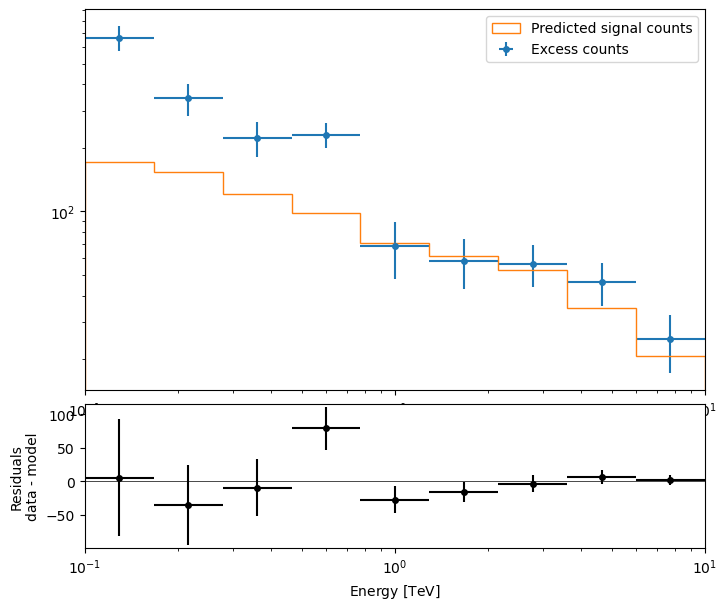

In [237]:
ds1_sp.plot_fit()

<Axes: >

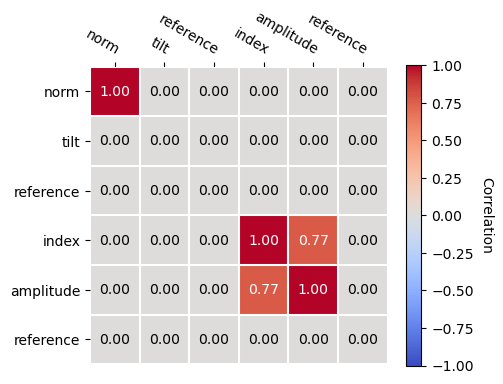

In [238]:
models_sp.covariance.plot_correlation()

In [239]:
models_sp.covariance = Covariance(data=result_sp.covariance_result.matrix, 
                                  parameters=result_sp.models.parameters)

<Axes: >

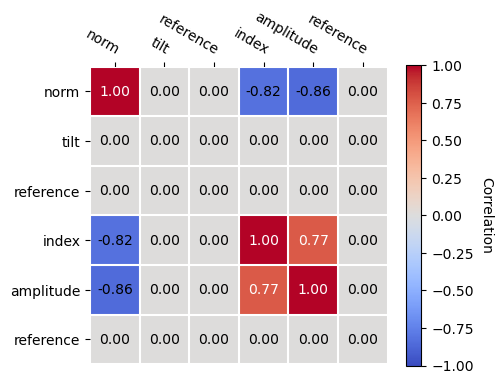

In [240]:
models_sp.covariance.plot_correlation()

In [241]:
contour_sp = fit.stat_contour(
                datasets=ds1_sp,
                x=models_sp.parameters["norm"],
                y=models_sp.parameters["amplitude"],
                numpoints=11,
                sigma=1,
            )

In [242]:
contour_sp

{'spectral_ds-bkg.spectral.norm': array([1.04561143, 1.05098659, 1.05995529, 1.07056578, 1.0870684 ,
        1.08992544, 1.08611638, 1.0785209 , 1.06787211, 1.06084798,
        1.04850092, 1.04561143]),
 'model1.spectral.amplitude': array([2.58713886e-12, 2.35971888e-12, 2.13241225e-12, 1.90516428e-12,
        1.67826809e-12, 1.75097376e-12, 1.97388399e-12, 2.19669734e-12,
        2.41942050e-12, 2.53071986e-12, 2.64155504e-12, 2.58713886e-12]),
 'success': True}

Text(0, 0.5, 'model1.spectral.amplitude')

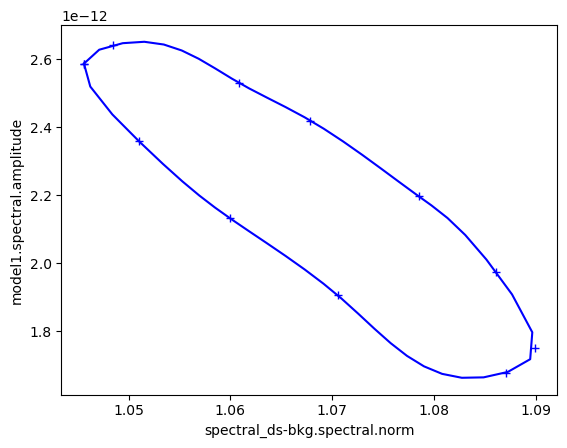

In [246]:
ax= plt.subplot()
plot_contour_line(ax=ax,
                  x=contour_sp['spectral_ds-bkg.spectral.norm'],
                  y=contour_sp['model1.spectral.amplitude'])
ax.set_xlabel('spectral_ds-bkg.spectral.norm')
ax.set_ylabel('model1.spectral.amplitude')